In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy import stats
from scipy.ndimage import convolve
from skimage import io, color, img_as_float
from skimage.filters import threshold_otsu
import cv2
import pywt
from scipy.ndimage import uniform_filter
from skimage import io, util
from skimage.filters import roberts, prewitt, sobel
from skimage.feature import canny

# Load a sample images
flower = cv2.cvtColor(cv2.imread('images/flower.jpg'), cv2.COLOR_BGR2RGB)
veg = cv2.cvtColor(cv2.imread('images/veg.png'), cv2.COLOR_BGR2RGB)
girl= cv2.cvtColor(cv2.imread('images/girl2.png'), cv2.COLOR_BGR2RGB)

# Convert images to Grayscale
flower_img = cv2.cvtColor(flower, cv2.COLOR_RGB2GRAY)
veg_img = cv2.cvtColor(veg, cv2.COLOR_RGB2GRAY)
girl_img = cv2.cvtColor(girl, cv2.COLOR_RGB2GRAY)

line_path = 'images/line.png'
line_img = cv2.imread(line_path, cv2.IMREAD_GRAYSCALE)

h_path = 'images/h.png'
h_img = cv2.imread(h_path, cv2.IMREAD_GRAYSCALE)

def show_images(images, titles, images_per_row=3, cmap='gray'):
    """Display a list of images using matplotlib."""
    num_images = len(images)
    num_rows = np.ceil(num_images / images_per_row).astype(int)
    
    # Set the figure size to closely match the manual plot example (15, 5)
    figure_width = 15  # Fixed width
    figure_height = 5 * num_rows  # Adjusted by the number of rows

    plt.figure(figsize=(figure_width, figure_height))

    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(num_rows, images_per_row, i + 1)
        # If images have different ranges, you might want to set vmin and vmax
        # to the min and max of each image respectively:
        # vmin, vmax = image.min(), image.max()
        # Or, for normalized images, you can omit vmin and vmax to use the default behavior
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Understanding Digital Image Processing

## 7. Image Segmentation

### 7.1 Introduction
Image segmentation is a fundamental process in the field of image analysis and computer vision. It involves partitioning an image into distinct regions where each segment is consistent regarding specific attributes such as color, intensity, or texture. The objective of segmentation is to simplify or change the representation of an image into something more meaningful and easier to analyze.

Segmentation is crucial because it is often the first step in higher-level image processing tasks, such as object detection, pattern recognition, and image classification. The performance of these advanced tasks greatly depends on the precision of the segmentation.

Some real-world applications of image segmentation include:
- In industrial automation, segmentation assists in the inspection of electronic components.
- Remote sensing uses segmentation to differentiate between various landforms in satellite imagery.
- In medical imaging, segmentation helps identify and isolate anatomical structures in MRI and X-ray scans.

Different researchers and practitioners have provided varied definitions of image segmentation, which can be summarized as follows:
- **Computer Vision Perspective**: It is the division of a digital image into multiple segments to simplify the representation of the image, making it more analyzable.
- **Attribute Similarity Perspective**: It involves grouping pixels that have similar characteristics or features.
- **Homogeneity Perspective**: It defines segmentation as the process of dividing an image into non-overlapping regions where each region is uniform according to some criterion, and no union of two adjacent regions is homogeneous.

Image processing activities are often categorized into three levels:
- **Low-Level**: Concerned with primitive operations such as noise reduction, contrast enhancement, and image sharpening.
- **Mid-Level**: Includes tasks like segmentation, description of those regions, and object recognition.
- **High-Level**: Involves the cognitive processes corresponding to visual perception and interpretation (e.g., object recognition at the semantic level).

Image segmentation is pivotal in both mid-level and high-level processing stages, serving as a bridge between raw pixel data and semantic interpretation.

### 7.2 Techniques of Image Segmentation

There is no one-size-fits-all approach to image segmentation, and it remains a challenging problem, particularly for complex images. Numerous segmentation techniques have been developed, each with its own strengths and suitable application contexts. These techniques are generally categorized based on two principles of intensity values: discontinuity and similarity.

- **Discontinuity-Based Techniques**: These methods focus on identifying sudden changes in intensity, which typically correspond to the boundaries of objects within an image. Common discontinuity-based methods include edge detection algorithms like the Sobel, Canny, and Prewitt operators.

- **Similarity-Based Techniques**: In contrast, these methods aim to group together pixels that share similar attributes according to predefined criteria such as color, intensity, or texture. Clustering methods like K-means, region growing, and thresholding are examples of similarity-based segmentation.

The classification of segmentation techniques can be visualized in a hierarchical structure, with the primary differentiation based on whether the technique is leveraging discontinuity or similarity of pixel values.

In practice, choosing the right segmentation technique depends on the specific characteristics of the image and the requirements of the subsequent image analysis task. Advanced segmentation methods might combine multiple basic techniques or incorporate machine learning to improve robustness and accuracy.
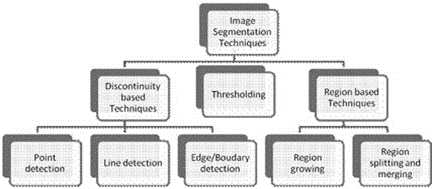

### 7.3 Discontinuity-based Image Segmentation Techniques
Discontinuity-based techniques are a fundamental category of image segmentation that identify segments within an image based on sudden changes in intensity, such as points, lines, and edges. These abrupt changes often correspond to the boundaries and features of objects within the image.

#### 7.3.1 Point Detection
Point detection is a technique used to identify pixels that differ significantly in intensity from their surroundings. This can be indicative of noise, specific features, or textured areas within an image. The process of point detection typically involves the following steps:

1. **Mask Application**: A convolutional mask (also known as a kernel or filter) is applied to the image. This mask is designed to highlight points by accentuating the intensity difference between a pixel and its neighbors.

2. **Thresholding**: After mask application, a thresholding step is performed. If the processed value at the mask's central location is greater than a predefined non-negative threshold, a point is detected.

The process can be described algorithmically as:

- Apply a mask similar to that shown in Fig. 7.2, which emphasizes the central pixel's intensity difference with its neighbors.
- Use thresholding to determine which points are significantly different from their surroundings based on the processed mask values.

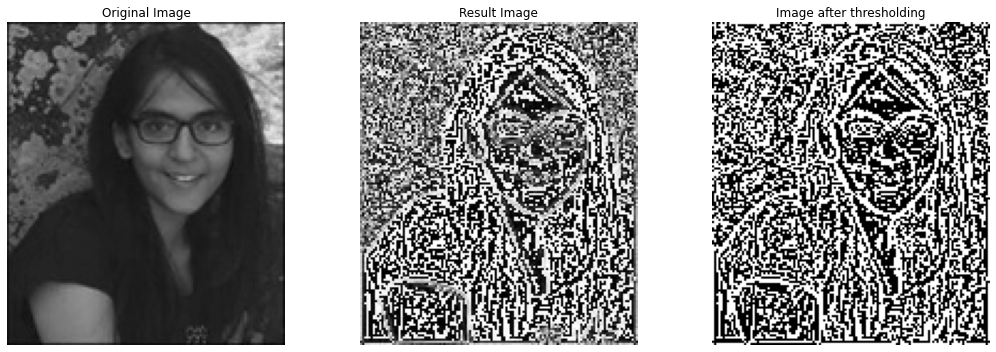

In [2]:
# Read and preprocess the image
image = girl_img

# Define the point detection mask (Laplacian)
point_mask = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])

# Apply the mask using convolution
processed_image = convolve(image, point_mask)

# Apply thresholding
thresh = threshold_otsu(processed_image)  # Otsu's method to find the threshold
point_detected_image = processed_image > thresh

# Display the results
show_images([girl_img, processed_image, point_detected_image], 
            ['Original Image', 'Result Image', 'Image after thresholding'])

When selecting a threshold, it's important to consider the image's characteristics and the nature of the points you wish to detect. The threshold value can significantly affect the outcome, potentially including or excluding points based on their intensity.

An alternative point detection approach involves examining the neighborhood of each pixel. If the difference between the maximum and minimum pixel intensity within the neighborhood exceeds a certain threshold, the central pixel can be classified as a point of interest.

#### 7.3.2 Line Detection
Line detection plays a critical role in many image processing applications. It serves as a building block for more complex tasks such as object recognition, computer vision, and automated document analysis. The goal of line detection is to locate and delineate the linear features within an image, which often correspond to object boundaries, text, or other significant structural elements.

To achieve this, we use convolution masks, which are specially designed matrices that highlight specific patterns within an image when applied through convolution. These patterns correspond to lines in particular orientations.

Here are some commonly used masks for line detection:

(a) Horizontal line detection mask:
$$
\begin{bmatrix}
    -1 & -1 & -1 \\
     2 &  2 &  2 \\
    -1 & -1 & -1
\end{bmatrix}
$$
This mask is used to enhance horizontal lines in an image while suppressing other features.

(b) 135-degree line detection mask:
$$
\begin{bmatrix}
     2 & -1 & -1 \\
    -1 &  2 & -1 \\
    -1 & -1 &  2
\end{bmatrix}
$$
This mask targets lines that are oriented at a 135-degree angle from the horizontal axis.

(c) Vertical line detection mask:
$$
\begin{bmatrix}
    -1 &  2 & -1 \\
    -1 &  2 & -1 \\
    -1 &  2 & -1
\end{bmatrix}
$$
It detects lines that run vertically through the image.

(d) 45-degree line detection mask:
$$
\begin{bmatrix}
    -1 & -1 &  2 \\
    -1 &  2 & -1 \\
     2 & -1 & -1
\end{bmatrix}
$$
This mask is designed to highlight lines oriented at a 45-degree angle.

Each mask accentuates the line intensity in the direction it is designed for while diminishing the intensity of pixels not forming a line in that orientation. The process for line detection using these masks involves several steps:

1. **Convolution**: Each mask is convolved with the image to produce a set of response maps. Convolution is a mathematical operation that computes the sum of element-wise products between the mask and the image region it covers, sliding across the entire image.

2. **Combining Responses**: The absolute values of the convolution results from each mask are combined pixel-wise. At each pixel location (x, y), we determine the composite response `R(x, y)`, which is the maximum of the absolute responses from all masks. Mathematically, this is represented as:

    $$ R(x, y) = \max(|R_1(x, y)|, |R_2(x, y)|, |R_3(x, y)|, |R_4(x, y)|) $$

3. **Thresholding**: The composite response matrix `R` is then thresholded. If the response at a pixel exceeds a predetermined threshold `T`, it indicates a line presence at that pixel. The choice of `T` is critical—it must be high enough to exclude noise and low enough to retain genuine line features.

By considering the maximum response across different orientations, we can detect lines without bias towards any single direction, ensuring that all significant lines are identified.

In summary, line detection using convolution masks is an elegant method that leverages the principles of signal processing to extract valuable structural information from images. Students should familiarize themselves with the underlying mathematical operations and practice applying these techniques to various images to gain a deeper understanding of their effectiveness and limitations.

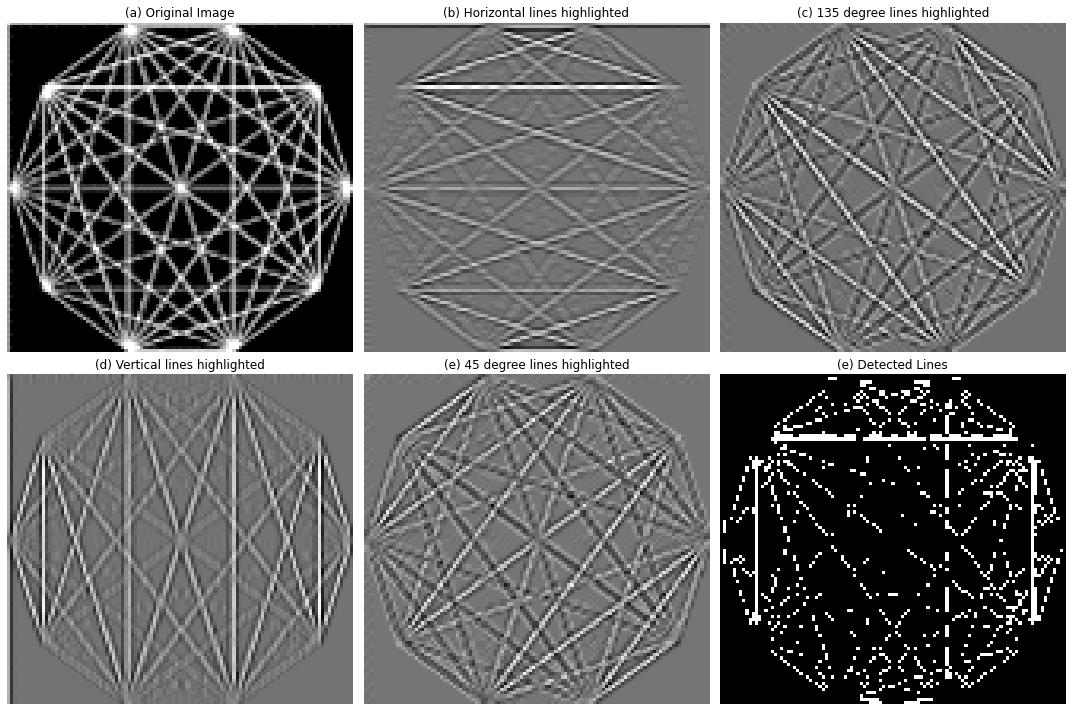

In [3]:
image = line_img.astype(np.float32) / 255.0

# Define the line detection masks
masks = [
    np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]]),  # Horizontal
    np.array([[2, -1, -1], [-1, 2, -1], [-1, -1, 2]]),  # 135 degrees
    np.array([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]]),  # Vertical
    np.array([[-1, -1, 2], [-1, 2, -1], [2, -1, -1]])   # 45 degrees
]

# Apply each mask and store responses
responses = [convolve(image, mask) for mask in masks]

# Compute the maximum response across all orientations
max_response = np.max([np.abs(response) for response in responses], axis=0)

# Apply thresholding to the maximum response to detect lines
threshold = np.max(max_response) * 0.5  # Example threshold value
lines_detected = max_response > threshold

# Collect images and titles for displaying
images_to_show = [image] + responses + [lines_detected]
titles = ['(a) Original Image'] + \
         [f'({chr(ord("b") + i)}) {orientation} lines highlighted' 
          for i, orientation in enumerate(["Horizontal", "135 degree", "Vertical", "45 degree"])] + \
         ['(e) Detected Lines']

# Use the provided function to display the images
show_images(images_to_show, titles)


#### 7.3.3 Edge Detection
Edge detection is a critical process in image processing and computer vision, serving as the foundation for a variety of applications. An edge is characterized by a significant transition in pixel intensity from one region of an image to another. This abrupt change often signifies the boundaries of objects within the image, providing valuable information about the location, shape, and size of various elements in the scene.

Edges are not just lines but can represent the contours and outlines that define the structure of objects in an image. For instance, digital artists often utilize edge detection to create striking outlines in their artwork, enhancing visual appeal or emphasizing certain features.

##### Importance of Edges
Edges contain essential information that can reduce the amount of data to be processed and filter out less important information. In essence, edges capture the structural essence of an image. By identifying edges, we can locate objects, understand the scene better, and even enhance images by sharpening the boundaries of objects, which can be particularly useful in both artistic and technical fields.

##### Varieties of Edges
Edges come in various forms and complexities:
- **Step Edges**: These are characterized by a sudden transition in intensity from one level to a distinctly different level. They represent clear boundaries and are often the result of a direct overlap of distinct regions.
- **Ramp Edges**: In real-world scenarios, ideal step edges are often blurred due to factors like camera focus, resulting in a gradual change in intensity known as ramp edges.
- **Line Edges**: These occur when an edge doesn’t result in an immediate transition from one intensity to another but instead is formed by a thin line of pixels that contrast with the background.
- **Roof Edges**: When line edges get blurred, they tend to form a roof-like structure in the intensity graph, thus the name roof edges.
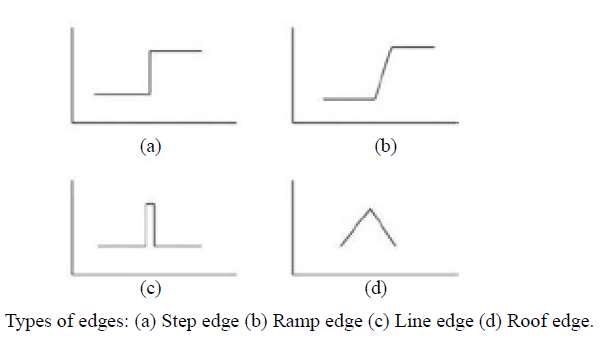

##### Applications

Edge detection is not just limited to artistic endeavors but also plays a vital role in practical applications such as:
- Object detection and tracking
- Feature extraction for recognition systems
- Image enhancement and sharpening
- Boundary detection for medical imaging analysis
- Scene reconstruction in 3D modeling

### 7.3.3.1 Gradient-based Edge Detection
In image processing, the concept of a gradient is pivotal for detecting edges. The gradient of an image maps the rate of change in intensity at every point in the image. Mathematically, for an image represented by the function $ f(x,y) $, the gradient is a two-dimensional vector of the first order partial derivatives in the x and y directions and is computed as:

$$
\nabla f = \text{grad}(f) = \begin{bmatrix} G_x \\ G_y \end{bmatrix} = \begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}
$$

Here, $ G_x $ and $ G_y $ represent the gradient components along the x and y axes, respectively. The gradient vector, $ \nabla f $, efficiently represents both the magnitude and direction of the edge. It points in the direction of the greatest rate of intensity increase.

#### Magnitude and Direction of the Gradient
The magnitude of the gradient vector, denoted as $ | \nabla f | $ or $ \text{mag}(\nabla f) $, gives the rate of change in intensity and is calculated using the formula:

$$
| \nabla f | = \text{mag}(\nabla f) = \sqrt{G_x^2 + G_y^2}
$$

The direction of the gradient, $\theta(x, y) $, indicates the orientation of the edge and is given by:

$$
\theta(x, y) = \tan^{-1} \left( \frac{G_y}{G_x} \right)
$$

The magnitude and direction images, $ \text{mag}(\nabla f) $ and $ \theta(x, y) $, are the same size as the original image $ f(x,y) $ and contain the edge strength and orientation information, respectively.

#### Gradient Images
The term "gradient image" typically refers to the magnitude of the gradient, and it is a crucial step in edge detection methods. Some common gradient-based edge detection algorithms include the Roberts, Prewitt, and Sobel operators.

#### Roberts Cross Edge Detector
The Roberts Cross Edge Detector is an algorithm for identifying edges in an image based on the gradient. It employs two simple 2x2 convolution masks that emphasize diagonal edges within the image:

- The x-component mask $G_x $ is designed to respond to edges at a 45-degree angle.
- The y-component mask $G_y $ highlights edges at a 135-degree angle.

The Roberts operator is computationally efficient as it processes only four pixels at a time using simple addition and subtraction. This makes it a swift technique for edge detection. However, due to the small size of the kernel, it can be sensitive to noise and may produce unsatisfactory results when edges are not sharp.
 
$$
\begin{bmatrix}
    -1 & 0 \\
     0 & 1
\end{bmatrix}
$$
$$G_x $$

$$
\begin{bmatrix}
     0 & -1 \\
     1 & 0
\end{bmatrix}
$$
$$G_y $$

$$ Roberts \, mask. $$

#### Prewitt Edge Detector
The Prewitt operator is another gradient-based edge detector that uses two 3x3 masks to discern horizontal and vertical edges:

- The x-component mask $ G_x $ detects horizontal edges.
- The y-component mask $ G_y $ is for vertical edges.

It is a relatively quick method and computationally less demanding. Like the Roberts operator, the Prewitt operator can struggle with noisy and low-contrast images.

$$
\begin{bmatrix}
    -1 & -1 & -1 \\
     0 &  0 & 0  \\
     1 &  1 & 1
\end{bmatrix}
$$
$$G_x $$

$$
\begin{bmatrix}
    -1 & 0 & 1 \\
    -1 & 0 & 1  \\
    -1 & 0 & 1
\end{bmatrix}
$$
$$G_y $$

$$ Prewitt \, mask. $$

#### Sobel Edge Detector
The Sobel operator is similar to the Prewitt operator but includes higher weight in the center columns and rows of its masks, which contributes to a smoothing effect:

- The Sobel operator also targets horizontal and vertical edges.
- Due to the larger mask size, it is less noise-sensitive and tends to produce stronger responses for similar edges when compared to the Roberts Cross.

Although the Sobel operator is slower than the Roberts Cross, it compensates for this by being more robust to noise. However, this robustness can also result in thicker natural edges, so some post-processing thinning might be necessary.

$$
\begin{bmatrix}
    -1 & -2 & -1 \\
     0 &  0 & 0  \\
     1 &  2 & 1
\end{bmatrix}
$$
$$G_x $$

$$
\begin{bmatrix}
    -1 & 0 & 1 \\
    -2 & 0 & 2  \\
    -1 & 0 & 1
\end{bmatrix}
$$
$$G_y $$

$$ Sobel \, mask. $$

#### Comparative Summary
- **Roberts Cross**: Fast, simple, but noise-sensitive and can miss non-diagonal edges. Ideal for high-contrast images with minimal noise. Watch out for its sensitivity to noise.
- **Prewitt**: Slightly more complex, better at detecting horizontal and vertical edges, but still not ideal for noisy images. A good balance for detecting horizontal and vertical edges quickly. However, be cautious with noisy images.
- **Sobel**: More complex and slower, but produces stronger edge responses and is less sensitive to noise. Preferred when dealing with images that have a significant amount of noise or require smoother edge detection.

#### Canny Edge Detection Algorithm
The Canny edge detection algorithm, proposed by John F. Canny in 1986, is a multi-stage process that detects a wide range of edges in images. It is known for its optimality in the following three criteria:

1. **Detection**: The algorithm aims to maximize the detection of real edges while minimizing false detection. It focuses on maximizing the signal-to-noise ratio.
2. **Localization**: The detected edges should be as close as possible to the actual edges in the image.
3. **Minimal Response**: Ideally, one real edge should only correspond to one detected edge to prevent multiple detections of the same edge.

##### Steps of the Canny Edge Detection Algorithm

1. **Smoothing**:
   - The image is first smoothed using a Gaussian filter to reduce noise, which could lead to false edge detection.

2. **Finding Gradients**:
   - Edges are identified where the gradients of the image are large. Gradients are computed using Sobel masks in the x and y directions.
   - The edge strength, or gradient magnitude, is calculated using either the Euclidean distance:
   
     $$ |G| = \sqrt{G_x^2 + G_y^2} $$
     
   - Alternatively, the Manhattan distance can be used to reduce computational complexity:
   
     $$ |G| = |G_x| + |G_y| $$
     
   - The edge direction is determined using the arctangent:
   
     $$ \theta = \tan^{-1}\left(\frac{|G_y|}{|G_x|}\right) $$

3. **Non-Maximum Suppression**:
   - This step sharpens the edges by retaining only the local maxima in the direction of the gradient, effectively thinning the edges.

4. **Double Thresholding**:
   - To differentiate between true and potential edges, two thresholds are set: a lower threshold (L) and a higher threshold (H).
   - Edge pixels stronger than H are marked as strong edges, while those between L and H are marked as weak edges. Pixels weaker than L are discarded.

5. **Edge Tracking by Hysteresis**:
   - Strong edges are automatically considered as true edges.
   - Weak edges are only considered true if they are connected to strong edges, as they may be noise or color variations. This is done through edge tracking, which is implemented via BLOB-analysis.

##### Advantages of the Canny Edge Detector
- The Canny edge detector is capable of detecting edges in noisy images with good accuracy, thanks to the initial Gaussian smoothing.
- It produces one-pixel-wide ridges, enhancing the signal-to-noise ratio via non-maximum suppression.
- The algorithm applies double thresholding and edge tracking by hysteresis to improve detection accuracy.

##### Drawbacks
- The Canny edge detector can be computationally intensive, making real-time implementation challenging.

##### Conclusion for Students
The Canny edge detector is renowned for its ability to accurately detect edges within noisy environments and is considered one of the best edge detection algorithms. Its multi-stage process allows for clear and precise edge detection suitable for various applications. When implementing edge detection, the Canny algorithm can be an excellent choice, but it's essential to consider the computational requirements and the nature of the image being processed.

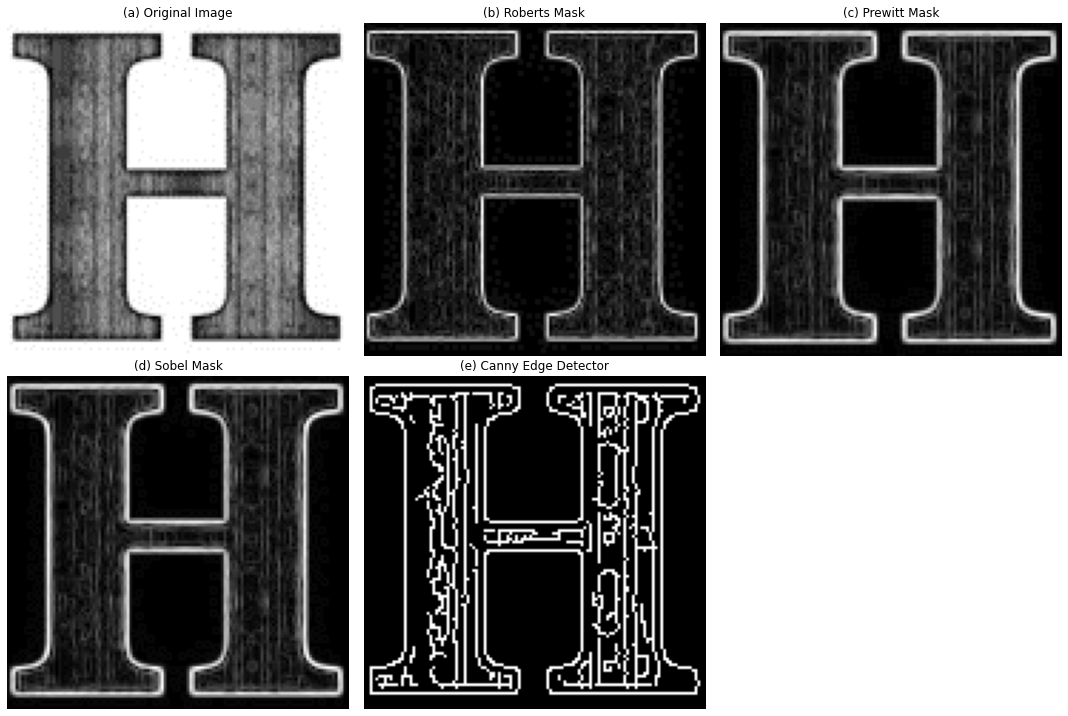

In [4]:
# Apply Gaussian blur to reduce noise (optional but recommended)
blurred_image = cv2.GaussianBlur(h_img, (5, 5), 0)

image = h_img.astype(np.float32) / 255.0

# Apply gradient-based edge detection techniques
roberts_edges = roberts(image)
prewitt_edges = prewitt(image)
sobel_edges = sobel(image)
#canny_edges = canny(image)
canny_edges = cv2.Canny(blurred_image, threshold1=30, threshold2=100)  # Adjust the thresholds as needed

# Collect images and their titles for displaying
images_to_show = [image, roberts_edges, prewitt_edges, sobel_edges, canny_edges]
titles = ['(a) Original Image', '(b) Roberts Mask', '(c) Prewitt Mask', 
          '(d) Sobel Mask', '(e) Canny Edge Detector']

# Use the provided function to display the images
show_images(images_to_show, titles)

### 7.4	Thresholding-based Image Segmentation
Thresholding is a fundamental technique in image segmentation that is favored for its simplicity, efficiency, and ease of implementation. This method operates on the principle of pixel intensity differentiation, effectively categorizing image pixels into distinct segments, typically foreground (objects) and background.

##### How Thresholding Works
The process involves selecting a threshold value, and then all pixels in the image are classified based on this value:

- Pixels with intensity above the threshold are considered part of the foreground.
- Pixels with intensity below the threshold are assigned to the background.

As a result, thresholding transforms the original grayscale or color image into a binary image, which is composed solely of two pixel values, often 0 for background and 1 for foreground.

##### Applications

Thresholding is particularly effective in scenarios where there is a clear distinction in gray level values between objects and their background, making it a staple in applications such as:

- Document scanning and text recognition
- Medical imaging for identifying anatomical structures
- Industrial imaging for defect detection
- Object recognition and tracking in video streams

#### Types of Thresholding

1. **Global Thresholding**:
   - A single threshold value is applied to the entire image.
   - This method assumes that the image has a bimodal histogram, where the foreground and background can be easily separated.
   - Global thresholding is straightforward but may not perform well on images with varying lighting conditions or complex backgrounds.

2. **Variable (Local or Adaptive) Thresholding**:
   - Different threshold values are computed for different regions of the image.
   - This approach adapts to changes in lighting and other local variations within the image, leading to more accurate segmentation, especially in challenging conditions.
   - It is more computationally intensive but provides better results for complex images.